<a href="https://colab.research.google.com/github/saadatialirezam-create/bioinformatics-project/blob/main/occlusion_without_leakage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
with open('/content/drive/MyDrive/brain_tumor_lists_resized.pkl', 'rb') as f:
    data = pickle.load(f)

notumor_imgs_resized = data['notumor']
pituitary_imgs_resized = data['pituitary']
meningioma_imgs_resized = data['meningioma']
glioma_imgs_resized = data['glioma']

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

X = (notumor_imgs_resized +
     pituitary_imgs_resized +
     meningioma_imgs_resized +
     glioma_imgs_resized)

y = ([0]*len(notumor_imgs_resized) +
     [1]*len(pituitary_imgs_resized) +
     [2]*len(meningioma_imgs_resized) +
     [3]*len(glioma_imgs_resized))

X = np.array(X, dtype=np.uint8)
y = np.array(y, dtype=np.int32)

print("Total:", X.shape, y.shape)
print("Class counts:", np.bincount(y))

# 2) test 20%
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 3) val 10%
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.125,
    random_state=42,
    stratify=y_trainval
)

print("Train:", X_train.shape, y_train.shape, "counts:", np.bincount(y_train))
print("Val:  ", X_val.shape, y_val.shape, "counts:", np.bincount(y_val))
print("Test: ", X_test.shape, y_test.shape, "counts:", np.bincount(y_test))

Total: (5712, 224, 224, 3) (5712,)
Class counts: [1595 1457 1339 1321]
Train: (3997, 224, 224, 3) (3997,) counts: [1116 1019  937  925]
Val:   (572, 224, 224, 3) (572,) counts: [160 146 134 132]
Test:  (1143, 224, 224, 3) (1143,) counts: [319 292 268 264]


In [4]:
import numpy as np
from PIL import Image

def occlude_image_resize_donor(img, same_class_imgs, patch_size=32):
    H, W = img.shape[:2]

    donor = same_class_imgs[np.random.randint(len(same_class_imgs))]

    donor_small = np.array(Image.fromarray(donor).resize((patch_size, patch_size)))

    x = np.random.randint(0, W - patch_size + 1)
    y = np.random.randint(0, H - patch_size + 1)

    out = img.copy()
    out[y:y+patch_size, x:x+patch_size, :] = donor_small
    return out

def build_occlusion_list(img_list, patch_size=32):
    occluded_list = []

    for img in img_list:
        occluded = occlude_image_resize_donor(img, img_list, patch_size)
        occluded_list.append(occluded)

    return occluded_list

In [5]:
X_train_occluded = build_occlusion_list(list(X_train), patch_size=32)

X_train_final = np.concatenate([X_train, np.array(X_train_occluded, dtype=np.uint8)], axis=0)
y_train_final = np.concatenate([y_train, y_train], axis=0)

print("Train final:", X_train_final.shape, y_train_final.shape)

Train final: (7994, 224, 224, 3) (7994,)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

NUM_CLASSES = 4
IMG_SIZE = 224

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)

outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

hist = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=2
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4)              │     4,054,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/30
250/250 - 183s - 734ms/step - accuracy: 0.4924 - loss: 1.3090 - val_accuracy: 0.2308 - val_loss: 2.2007
Epoch 2/30
250/250 - 29s - 114ms/step - accuracy: 0.6704 - loss: 0.8488 - val_accuracy: 0.2308 - val_loss: 1.7304
Epoch 3/30
250/250 - 29s - 115ms/step - accuracy: 0.7372 - loss: 0.7200 - val_accuracy: 0.4965 - val_loss: 1.6352
Epoch 4/30
250/250 - 29s - 116ms/step - accuracy: 0.7757 - loss: 0.6119 - val_accuracy: 0.7430 - val_loss: 0.6177
Epoch 5/30
250/250 - 29s - 117ms/step - accuracy: 0.8195 - loss: 0.4907 - val_accuracy: 0.7185 - val_loss: 1.1385
Epoch 6/30
250/250 - 29s - 117ms/step - accuracy: 0.8516 - loss: 0.4258 - val_accuracy: 0.7552 - val_loss: 0.8066
Epoch 7/30
250/250 - 30s - 118ms/step - accuracy: 0.8877 - loss: 0.3295 - val_accuracy: 0.7762 - val_loss: 0.5925
Epoch 8/30
250/250 - 29s - 118ms/step - accuracy: 0.9112 - loss: 0.2507 - val_accuracy: 0.7762 - val_loss: 0.7825
Epoch 9/30
250/250 - 30s - 118ms/step - accuracy: 0.9182 - loss: 0.2738 - val_accuracy:

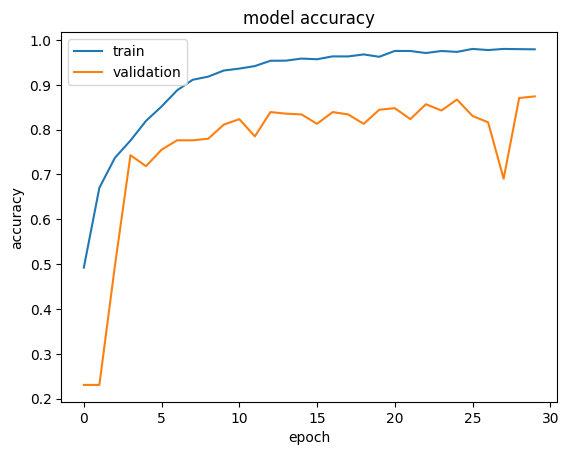

In [7]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [9]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - accuracy: 0.8865 - loss: 0.4723
Loss = 0.5255957841873169
Test Accuracy = 0.8827646374702454
